In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

### Препроцесс данных

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
df = pd.read_csv('JobSurveyIndia.csv')

In [4]:
df.isna().sum()

Unnamed: 0               0
Employment Sector        0
Employment Background    0
Public Dealing           0
Degree                   0
IdealNumberOfWorkdays    0
IdealYearlyIncome        0
dtype: int64

In [5]:
df = df.drop('Unnamed: 0', axis=1)

In [6]:
df.head()

,Employment Sector,Employment Background,Public Dealing,Degree,IdealNumberOfWorkdays,IdealYearlyIncome
0,Private Sector,Technical,No,Yes,4.0,More Than 1500K
1,Private Sector,Art,No,Yes,4.0,600K-900K
2,Government Sector,Technical,No,Yes,6.0,900K-1200K
3,Government Sector,Non-Technical,Yes,Yes,4.0,900K-1200K
4,Private Sector,Technical,No,Yes,5.0,1200K-1500K


In [7]:
df.describe()

,IdealNumberOfWorkdays
count,400.000000
mean,4.902500
std,0.805989
min,4.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,7.000000


In [8]:
def preproc_cat_features(sample):
    tok2id = {elem: idx for idx, elem in enumerate(sample.unique())}
    return sample.map(tok2id)

In [9]:
df['Employment Sector'] = preproc_cat_features(df['Employment Sector'])
df['Employment Background'] = preproc_cat_features(df['Employment Background'])
df['Public Dealing'] = preproc_cat_features(df['Public Dealing'])
df['Degree'] = preproc_cat_features(df['Degree'])
scaler = StandardScaler()
df['IdealNumberOfWorkdays'] = scaler.fit_transform(df[['IdealNumberOfWorkdays']])
df['IdealYearlyIncome'] = preproc_cat_features(df['IdealYearlyIncome'])

In [10]:
len(list(df['IdealYearlyIncome'].unique()))

4

In [11]:
targets = df['IdealYearlyIncome']
df = df.drop('IdealYearlyIncome', axis=1)
train_X, val_X, train_y, val_y = train_test_split(df, targets, test_size=.2)

In [12]:
class CustomDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.targets = torch.tensor(targets.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [13]:
train_dataset = CustomDataset(train_X, train_y)
test_dataset = CustomDataset(val_X, val_y)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

### Простая модель с SGD

In [14]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.fc(x)

### Модель с 1 слоем (скрытым)

In [15]:
class HiddenLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HiddenLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

### 3+ скрытых слоев

In [16]:
class DeepNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

### Обучение моделей

In [17]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for features, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        model.eval()
        correct_train, total_train = 0, 0
        correct_test, total_test = 0, 0
        
        with torch.no_grad():
            for features, targets in train_loader:
                outputs = model(features)
                _, predicted = torch.max(outputs, 1)
                total_train += targets.size(0)
                correct_train += (predicted == targets).sum().item()
            train_accuracy = correct_train / total_train
            train_losses.append(epoch_loss / len(train_loader))
            train_accuracies.append(train_accuracy)

            for features, targets in test_loader:
                outputs = model(features)
                _, predicted = torch.max(outputs, 1)
                total_test += targets.size(0)
                correct_test += (predicted == targets).sum().item()
            test_accuracy = correct_test / total_test
            test_losses.append(loss.item())
            test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

    return train_losses, test_losses, train_accuracies, test_accuracies

In [18]:
input_dim = train_X.shape[1]
output_dim = len(set(train_y))
hidden_dim = 64

In [19]:
simple_nn = SimpleNN(input_dim, output_dim)
hidden_layer_nn = HiddenLayerNN(input_dim, hidden_dim, output_dim)
deep_nn = DeepNN(input_dim, hidden_dim, output_dim)
optimizer_sgd = optim.SGD(simple_nn.parameters(), lr=0.01)
optimizer_adam = optim.Adam(hidden_layer_nn.parameters(), lr=0.001)
optimizer_adam_deep = optim.Adam(deep_nn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [20]:
print("Первая модель")
train_losses_simple, test_losses_simple, train_acc_simple, test_acc_simple = train_model(
    simple_nn, train_loader, test_loader, criterion, optimizer_sgd, epochs=10
)
print("-"*100)
print("Вторая модель")
train_losses_hidden, test_losses_hidden, train_acc_hidden, test_acc_hidden = train_model(
    hidden_layer_nn, train_loader, test_loader, criterion, optimizer_adam, epochs=10
)
print("-"*100)
print("Третья модель")
train_losses_deep, test_losses_deep, train_acc_deep, test_acc_deep = train_model(
    deep_nn, train_loader, test_loader, criterion, optimizer_adam_deep, epochs=10
)
print("-"*100)

Первая модель
Epoch 1/10, Loss: 1.6142, Train Accuracy: 0.1594, Test Accuracy: 0.0500
Epoch 2/10, Loss: 1.5021, Train Accuracy: 0.2062, Test Accuracy: 0.1250
Epoch 3/10, Loss: 1.4360, Train Accuracy: 0.2313, Test Accuracy: 0.3250
Epoch 4/10, Loss: 1.3942, Train Accuracy: 0.2313, Test Accuracy: 0.3250
Epoch 5/10, Loss: 1.3662, Train Accuracy: 0.3000, Test Accuracy: 0.4250
Epoch 6/10, Loss: 1.3450, Train Accuracy: 0.3312, Test Accuracy: 0.4250
Epoch 7/10, Loss: 1.3278, Train Accuracy: 0.3531, Test Accuracy: 0.4375
Epoch 8/10, Loss: 1.3125, Train Accuracy: 0.3563, Test Accuracy: 0.4500
Epoch 9/10, Loss: 1.2994, Train Accuracy: 0.3750, Test Accuracy: 0.4750
Epoch 10/10, Loss: 1.2876, Train Accuracy: 0.4219, Test Accuracy: 0.4875
----------------------------------------------------------------------------------------------------
Вторая модель
Epoch 1/10, Loss: 1.4161, Train Accuracy: 0.4594, Test Accuracy: 0.4500
Epoch 2/10, Loss: 1.2723, Train Accuracy: 0.4938, Test Accuracy: 0.5500
Epoch 

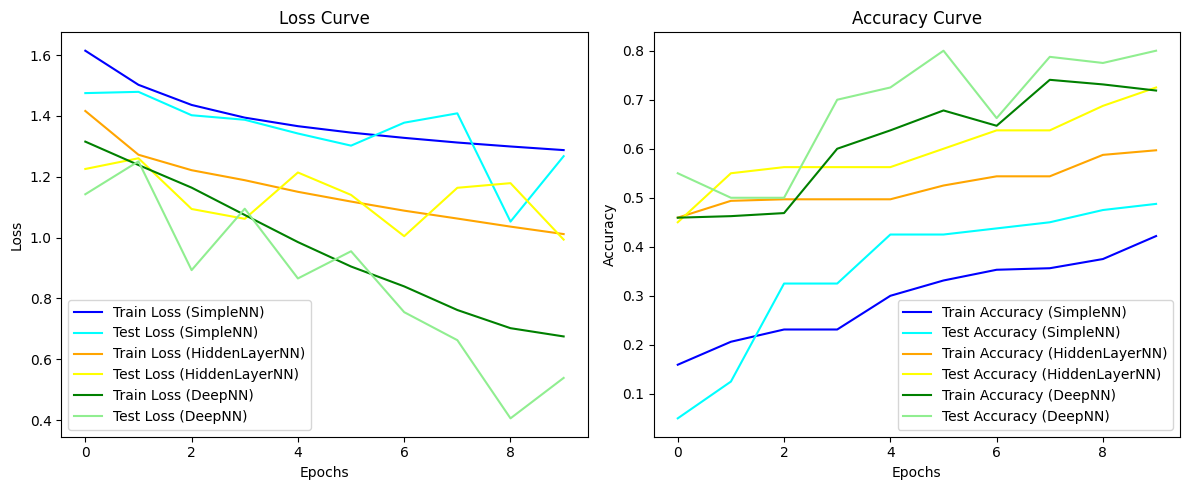

In [21]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_simple, label='Train Loss (SimpleNN)', color='blue')
plt.plot(test_losses_simple, label='Test Loss (SimpleNN)', color='cyan')
plt.plot(train_losses_hidden, label='Train Loss (HiddenLayerNN)', color='orange')
plt.plot(test_losses_hidden, label='Test Loss (HiddenLayerNN)', color='yellow')
plt.plot(train_losses_deep, label='Train Loss (DeepNN)', color='green')
plt.plot(test_losses_deep, label='Test Loss (DeepNN)', color='lightgreen')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_simple, label='Train Accuracy (SimpleNN)', color='blue')
plt.plot(test_acc_simple, label='Test Accuracy (SimpleNN)', color='cyan')
plt.plot(train_acc_hidden, label='Train Accuracy (HiddenLayerNN)', color='orange')
plt.plot(test_acc_hidden, label='Test Accuracy (HiddenLayerNN)', color='yellow')
plt.plot(train_acc_deep, label='Train Accuracy (DeepNN)', color='green')
plt.plot(test_acc_deep, label='Test Accuracy (DeepNN)', color='lightgreen')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
print("\nTrain and Test Accuracies:")
print("SimpleNN - Train Accuracy: {:.4f}, Test Accuracy: {:.4f}".format(train_acc_simple[-1], test_acc_simple[-1]))
print("HiddenLayerNN - Train Accuracy: {:.4f}, Test Accuracy: {:.4f}".format(train_acc_hidden[-1], test_acc_hidden[-1]))
print("DeepNN - Train Accuracy: {:.4f}, Test Accuracy: {:.4f}".format(train_acc_deep[-1], test_acc_deep[-1]))

best_model = "SimpleNN" if test_acc_simple[-1] > test_acc_hidden[-1] and test_acc_simple[-1] > test_acc_deep[-1] else (
    "HiddenLayerNN" if test_acc_hidden[-1] > test_acc_simple[-1] and test_acc_hidden[-1] > test_acc_deep[-1] else "DeepNN"
)

print(f"Лучшая модель: {best_model}")

pereobucheniye = any(train_acc > test_acc for train_acc, test_acc in zip(train_acc_deep, test_acc_deep))
print(f"Есть ли переобучение? {'Да' if pereobucheniye else 'Нет'}")

nedoobucheniye = (max(train_acc_simple) < 0.7 and max(train_acc_hidden) < 0.7 and max(train_acc_deep) < 0.7)
print(f"Есть ли недообучение? {'Да' if nedoobucheniye else 'Нет'}")


Train and Test Accuracies:
SimpleNN - Train Accuracy: 0.4219, Test Accuracy: 0.4875
HiddenLayerNN - Train Accuracy: 0.5969, Test Accuracy: 0.7250
DeepNN - Train Accuracy: 0.7188, Test Accuracy: 0.8000
Лучшая модель: DeepNN
Есть ли переобучение? Нет
Есть ли недообучение? Нет


### Чтобы улучшить метрики моделей, рассмотрите следующие стратегии:
- Увеличьте количество скрытых слоев и/или единиц.
- Экспериментируйте с различными функциями активации.
- Применяйте техники регуляризации (регуляризация L1/L2, Dropout).
- Используйте продвинутые оптимизаторы (например, AdamW) или планирование скорости обучения.
- Соберите больше данных или расширьте существующий набор данных.